# Neural Artistic Style Transfer

This interactive notebook shows how to use the python package `style` for performing artistic style transfer between a source and a style image.

![](etc/bridge_vangogh.png)
*Style transfer applied to a picture of the Golden Gate bridge using on Vincent van Gogh's 'The Starry Night' artistic style*

### Header

The following code loads auxilary components and defines helper functions.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Make sure we all see the same
np.random.seed(456);
torch.manual_seed(456);

### Import libary

Load the library and allocate the backbone (a modified pretrained network). Also instantiate an `IteratedStyleTransfer` that performs the reconstruction optimization.

In [3]:
import style
from style.utils import gallery, animate_progress

bb = style.Backbone()
st = style.IteratedStyleTransfer(bb)

### Transfer Style

The following shows how to adapt the style of a photo using one of Picasso's work as style. `style.IteratedStyleTransfer` is a generator object which by default only yields the final result, hence the call `next`.

100%|███████████████████████| 200/200 [33:39<00:00, 10.06s/it, loss=[1.510e-05 0.000e+00 1.397e-05 1.135e-06], lr=0.01]


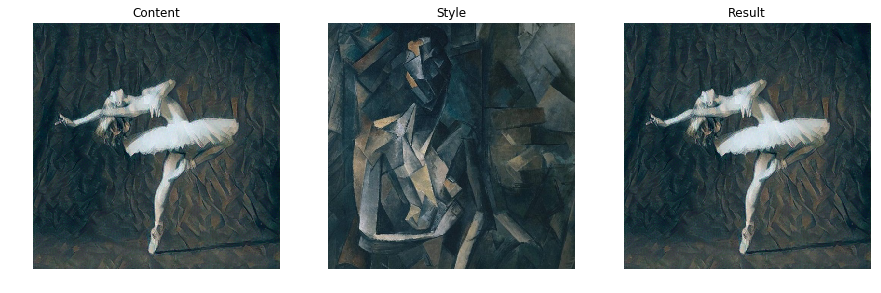

In [4]:
p = style.image.open('etc/dancing.jpg').scale_long_to(512)
a = style.image.open('etc/picasso.jpg').scale_long_to(512)

# Get generator
g = st.generate(
    content=style.Content(p, lambda_loss=0),
    style=style.GramStyle(a, [4,8,12,14]),
    seed=p)

# Get next (final) result
x = next(g)

gallery([('Content',p), ('Style',a), ('Result', x)], figsize=(15,8))
plt.show()

Since `style.IteratedStyleTransfer` is a generator we can also request to return intermediate result and render progress as a video.

In [7]:
p = style.image.open('etc/dancing.jpg').scale_long_to(256)
a = style.image.open('etc/picasso.jpg').scale_long_to(512)

g = st.generate(
    content=style.Content(p, lambda_loss=0),
    style=style.GramStyle(a, [4,8,12,14]),
    seed=p,
    yield_every=2,
    niter=100)

ani = animate_progress(g, p.shape, figsize=(5,5))

# from IPython.display import HTML
# HTML(ani.to_html5_video())

To receive just the final result, drop the `yield_every` field and call `next` on the generator to receive the final result. This is shown below with some parameters changed.

### Multiscale
Multiscaling performs style transfer on various image resolutions.


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [12:14<00:00, 213.99s/it]


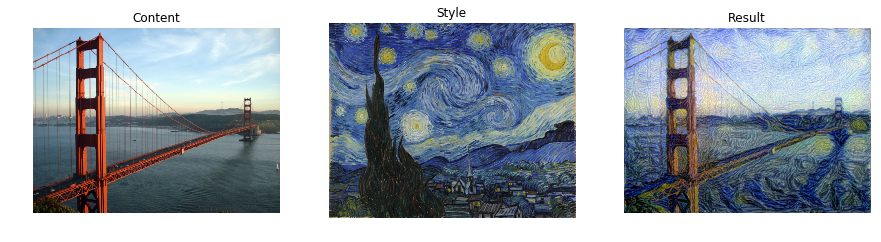

In [6]:
p = style.image.open('etc/bridge.jpg').scale_long_to(512)
a = style.image.open('etc/vangogh.jpg').scale_long_to(512)

g = st.generate_multiscale(
    content=style.Content(p),
    style=style.GramStyle(a), 
    seed=p,
    niter=100)

x = next(g)

gallery([('Content',p), ('Style',a), ('Result', x)], figsize=(15,8))
plt.show()

### Synthesize images

Generate artwork from styles by simply ignoring any content. In case you care for fine structures use `style.PatchStyle` otherwise go with `style.GramStyle` which is considerably faster.


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [12:19<00:00, 217.79s/it]


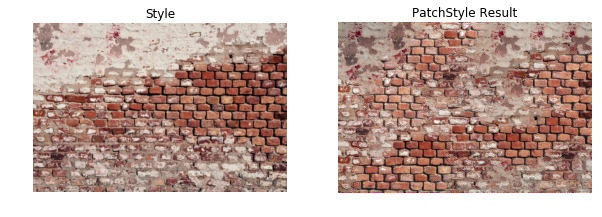

In [8]:
a = style.image.open('etc/wall.jpg').scale_long_to(256)

g = st.generate_multiscale(
    content=style.Content(lambda_loss=0),
    style=style.PatchStyle(a, [5,9], lambda_loss=1e-1),        
    seed=style.image.new_random_range(a.shape, 0.1, 0.95),
    niter=100)

x = next(g)

gallery([('Style',a), ('PatchStyle Result', x)], figsize=(10,8))
plt.show()

In comparison the `GramStyle` generates are more abstract version of the input.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:12<00:00, 38.44s/it]


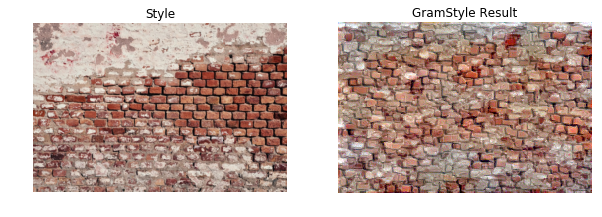

In [9]:
g = st.generate_multiscale(
    content=style.Content(lambda_loss=0),
    style=style.GramStyle(a, layer_ids=[5,9]),        
    seed=style.image.new_random_range(a.shape, 0.1, 0.95),
    niter=100)

x = next(g)

gallery([('Style',a), ('GramStyle Result', x)], figsize=(10,8))
plt.show()

### Semantic Maps

Incorporating semantic maps allows guided reconstructions. Both, the style image and the reconstruction image are attributed with semantic masks. This allows new compositions of the original style image. Special care has been taken to provide a memory efficient version that should be capable of generating larger images than would otherwise fit into your memory. 


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [10:27<00:00, 184.31s/it]


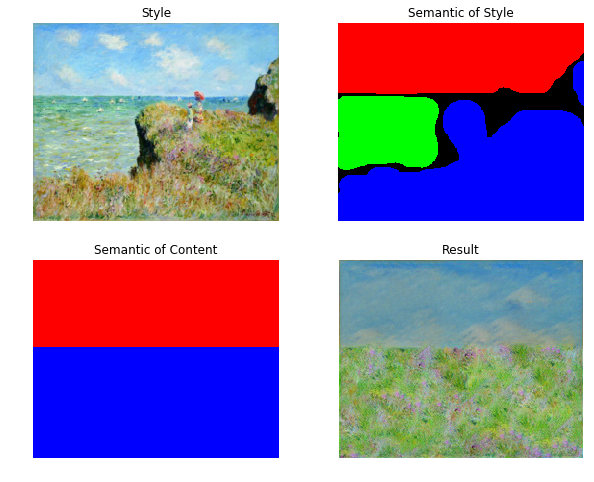

In [10]:
a_sem = \
    style.image.open('etc/monet_semantic.png') \
    .scale_long_to(256, resample=style.image.NEAREST)
    
a = \
    style.image.open('etc/monet.jpg') \
    .scale_long_to(256)

seed_sem = \
    style.image.open('etc/content_semantic.png') \
    .scale_to(a_sem.shape, resample=style.image.NEAREST)
    
seed = \
    style.image.new_random_range(seed_sem.shape, 0.1, 1)
    
    
sem_style = style.SemanticStyle(
    image=a, 
    semantic_style_image=a_sem, 
    semantic_content_image=seed_sem, 
    layer_ids=[5,9])

g = st.generate_multiscale(
    content=style.Content(lambda_loss=0),
    style=sem_style,
    seed=seed,
    niter=50)

# Below shows the reconstruction
x = next(g)

imgs = [('Style',a), ('Semantic of Style', a_sem), ('Semantic of Content', seed_sem), ('Result', x)]
gallery(imgs, rows=2, figsize=(10,8))
plt.show()

## Advanced usage

### Creating larger textures

Use the `style.TiledGeneration` when the image to be generated does not fit into the available memory.

In [12]:
a = style.image.open('etc/picasso.jpg').rotate(90).scale_long_to(512)

t = style.TiledGeneration(st)

kwargs = dict(
    border=64,
    style=style.GramStyle(a),
    niter=150,
    lambda_tv=0
)


seed = style.image.new_random_white((128,128,3), mean=a)

x = next(t.generate(seed, grid_shape=(1,1), **kwargs))    # 128x128
x.save('128.png')
x = next(t.generate(x.up(), grid_shape=(1,1), **kwargs))  # 256x256
x.save('256.png')
x = next(t.generate(x.up(), grid_shape=(2,2), **kwargs))  # 512x512
x.save('512.png')
x = next(t.generate(x.up(), grid_shape=(2,2), **kwargs))  # 1024x1024
x.save('1024.png')

# Uncomment following lines to generate higher resolutions.
#x = next(t.generate(x.up(), grid_shape=(4,4), **kwargs))  # 2048x2048
#x = next(t.generate(x.up(), grid_shape=(8,8), **kwargs))  # 4096x4096

x


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at ..\aten\src\TH\THGeneral.cpp:204

### Seamless
Seamless mode generates images that seamlessly tile at borders. That's convenient in case you want to stitch generated images horizontally or vertically.

In [ ]:
a = style.image.open('etc/water.jpg').scale_to(512)

border = 64
seamless = style.plugins.SeamlessPlugin(a.shape, border)

g = st.generate_multiscale(
    nlevels=3,
    content=style.Content(a, lambda_loss=0),
    style=style.GramStyle(a), 
    niter=200,
    plugins=[seamless],
)

x = style.image.borderless_view(next(g), border)

gallery([('Style', a), ('Result', x)], figsize=(10,8))
plt.show()

When stitched hardly any visual seams remain.

In [ ]:
# Visualize result
def stack(x, draw_seam_border=False):
    hs = np.hstack((x,x,x))
    vs = np.vstack((hs,hs,hs))

    if draw_seam_border:
        h,w = x.shape[:2]       
        vs[:, [w,2*w]] = 1
        vs[:, [w+1,2*w+1]] = 1
        vs[[h,2*h]]=1
        vs[[h+1,2*h+1]]=1

    return vs.view(style.image.Image)

g = stack(x, draw_seam_border=False)
gb = stack(x, draw_seam_border=True)

gallery([('Stacked 3x3',g), ('Stacked 3x3 border', gb)], figsize=(15,10))
plt.show()

Zoom to corner

In [ ]:
# Draw zoom at corner

z1 = g[x.shape[0]-100:x.shape[0]+100, x.shape[1]-100:x.shape[1]+100]
z2 = gb[x.shape[0]-100:x.shape[0]+100, x.shape[1]-100:x.shape[1]+100]

gallery([('Corner zoom',z1), ('Corner zoom border', z2)], figsize=(15,10))
plt.show()